# An Introduction to Pruning with CNNs

**Neural network compression** refers to a general suite of techniques used to reduce the size and computational complexity of deep learning models. As models grow increasingly large and complex, especially with the advent of deep architectures like ResNets, Vision Transformers, and Large Language Models (LLMs) like GPT, the demand for resources—both in terms of memory and computation—also escalates. This often limits the deployment of such models to environments with abundant resources, like data centers with specialized hardware. However, in many real-world applications, especially on edge devices, there is a critical need to run these models efficiently without sacrificing too much accuracy. Neural network compression addresses this need by reducing model size, which in turn lowers memory usage, speeds up inference times, and makes models more feasible to deploy in resource-constrained environments.

Pruning is a specific technique within the broader field of neural network compression, originating from @NIPS1989_6c9882bb. It involves systematically removing parts of the neural network that are deemed unnecessary or less important, thereby simplifying the model. The underlying idea is that not all parts of a neural network contribute equally to its final output. By identifying and removing less important components—such as weights, neurons, or even entire layers—pruning can maintain the model's performance while significantly reducing its size and complexity.

Pruning mechanisms typically involve evaluating the *importance* of different parts of a neural network based on certain criteria, such as the magnitude of weights or the activation levels. One common approach is to use the norms of these weights or activations—like the L1 or L2 norm—as a measure of their importance. Weights or activations with lower norms are often considered less critical and are candidates for pruning. By setting a threshold, parts of the network that fall below this threshold can be pruned, while the more significant components are retained. This selective pruning allows the model to remain functional, albeit in a more compact form.

<div style="text-align: center;">
  <img src="https://miro.medium.com/v2/resize:fit:967/1*rw2zAHw9Xlm7nSq1PCKbzQ.png" alt="pruning-styles" style="width:60%;">
</div>

As can be seen in the image above ([source](https://miro.medium.com/v2/resize:fit:967/1*rw2zAHw9Xlm7nSq1PCKbzQ.png)), pruning can be applied at various levels of granularity, ranging from fine-grained to more coarse-grained methods. Fine-grained pruning involves removing individual weights or neurons, offering the most precise level of control. This approach can lead to highly compact models but may require more sophisticated techniques to maintain performance. On the other end of the spectrum, coarse-grained pruning might involve removing entire channels or even layers from a model. For instance, in convolutional neural networks (CNNs), pruning might target entire filters or channels within a layer, leading to a more regular and structured reduction in model size. This type of pruning is often easier to implement and can lead to more predictable improvements in efficiency.

Pruning is not just limited to CNNs; it also has significant applicability to Large Language Models (LLMs), which are primarily composed of linear layers. Given the vast number of parameters in these models, pruning can be an effective way to reduce their size and make them more suitable for deployment in environments with limited resources. In LLMs, pruning might involve reducing the number of units in fully connected layers or simplifying the attention mechanisms. This can result in models that maintain their ability to understand and generate language while being much more efficient to run.

In this blog, we will focus on applying pruning techniques to Convolutional Neural Networks (CNNs). CNNs are particularly interesting for pruning because of their inherently structured nature, which makes them amenable to different granularities of pruning. This will be similar to the methodology followed in @han2015learningweightsconnectionsefficient.

Much of the code has been inspired from the labs of the [EfficientML.ai course by MIT](https://hanlab.mit.edu/courses/2024-fall-65940), which delves into efficient machine learning techniques. By examining CNNs through the lens of pruning, we aim to demonstrate how these techniques can be applied in practice to create more efficient models without compromising too much on performance.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets
from tqdm import tqdm

import matplotlib.pyplot as plt

## Readying our Model and Data

We'll start by downloading a pretrained VGG-16 model from `torchvision.models`. This allows us to utilize the pretrained model's learned features, providing a strong starting point for our pruning efforts.

We'll then evaluate its size and performance on the CIFAR-10 dataset after a little fine-tuning. This initial evaluation will help us establish a baseline, allowing us to understand the model's current capabilities in terms of both accuracy and resource usage. By doing so, we can better assess the impact of pruning techniques when we later modify the model to be more efficient. This benchmark will serve as a crucial reference as we explore different pruning strategies, ensuring that any changes we make can be directly compared to the original model's performance.

In [2]:
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)

In [3]:
batch_size = 64

root = "./data"
train_ds = datasets.CIFAR10(root=root,
                            train=True,
                            download=True,
                            transform=weights.transforms())
test_ds = datasets.CIFAR10(root=root,
                           train=False,
                           download=True,
                           transform=weights.transforms())
train_dl = DataLoader(train_ds, 
                      batch_size=batch_size,
                      shuffle=True)
test_dl = DataLoader(test_ds, 
                      batch_size=batch_size,
                      shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train_step(model, dataloader, criterion, optimizer, device):

    model.train()

    train_loss = 0.
    train_acc = 0.

    for step, (X, y) in tqdm(enumerate(dataloader), desc="Training", leave=False):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += ((y_pred == y).sum().item() / len(y))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    
    model.eval()

    eval_loss = 0.
    eval_acc = 0.

    for (X, y) in tqdm(dataloader, desc="Evaluating", leave=False):
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += ((y_pred == y).sum().item() / len(y))

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

In [5]:
# Finetune the model for 3 epochs
learning_rate = 1e-4
epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
    val_loss, val_acc = eval_step(model, test_dl, criterion, device)
    print(f"Epoch {epoch+1}... Train Accuracy: {train_acc:.2f} | Validation Accuracy: {val_acc:.2f}")

Epochs:  33%|███▎      | 1/3 [03:09<06:19, 189.96s/it]

Epoch 1... Train Accuracy: 0.77 | Validation Accuracy: 0.86


Epochs:  67%|██████▋   | 2/3 [06:18<03:08, 188.85s/it]

Epoch 2... Train Accuracy: 0.91 | Validation Accuracy: 0.89


Epochs: 100%|██████████| 3/3 [09:27<00:00, 189.08s/it]

Epoch 3... Train Accuracy: 0.95 | Validation Accuracy: 0.90


In [6]:
ckpt_path = "vgg16.pth"
torch.save(model.state_dict(), ckpt_path)

We'll define some utilities to get the number of parameters here and the size of the model in MB.

In [7]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

In [8]:
# Get original model size and benchmark accuracy
MB = 8 * 1024**2
orig_model_size = get_model_size(model)
_, orig_acc = eval_step(model, test_dl, criterion, device)

print(f"Original model accuracy: {orig_acc:.4f}")
print(f"Original model size: {orig_model_size/(MB)}")

Original model accuracy: 0.8985
Original model size: 527.7921447753906


## Starting with Pruning

The objective of pruning is to zero out the "unimportant" parts of the tensors within a neural network, effectively reducing the model's complexity without significantly impacting its performance. To determine which parts of the tensor are "unimportant," we rely on a heuristic that considers the absolute values of the tensor's elements. The idea is that values closer to zero contribute less to the network's overall function and can be pruned away with minimal impact. Mathematically, this heuristic can be expressed as $\text{importance} = |W|$, where $ W$ represents the weights of the network.

We begin with **fine-grained pruning**, where individual connections with the lowest importance are removed. 

This method allows us to carefully trim down the network by eliminating the least important elements of the weight tensors. To implement this, we can define a target sparsity level that we aim to achieve in the tensors. Using our heuristic, we can establish a threshold corresponding to this target sparsity, which guides us in creating a mask that zeros out the appropriate parts of the weight tensor.

Let's explore this approach in code below.

Number of elements in x: 1728


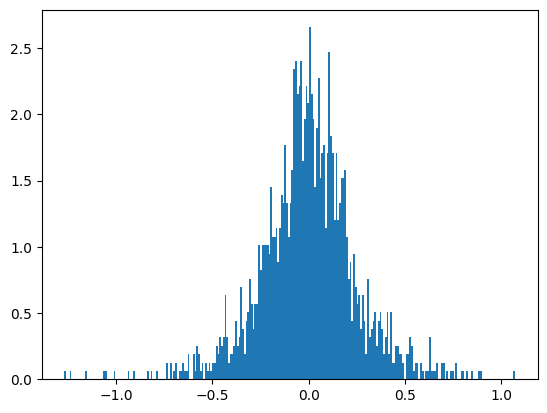

In [9]:
target_sparsity = 0.6

# Grab the weights of a conv layer
x = model.features[0].weight.data.detach().cpu()
num_el = x.numel()

print(f"Number of elements in x: {num_el}")

# Visualize the distribution
bins = 256
plt.hist(x.view(-1), bins=bins, density=True)
plt.show()

The distribution of the values in the tensor, as illustrated by the bell(-ish) curve in the figure, shows that most of the values cluster near the center, indicating that they have low magnitudes and are close to zero. 

This distribution is beneficial for pruning because the majority of the tensor's values are not crucial to the network's performance. When we apply thresholding, we effectively cut out the values near the center of the curve, which correspond to the less important elements.

By focusing on retaining the heavier elements found at the tails of the distribution, which have higher magnitudes and are likely more significant to the model's functionality, we can prune a substantial number of elements. This method allows us to reduce the size of the network considerably while preserving the most critical connections that contribute to the model's predictive power.

In [10]:
importance = torch.abs(x)

num_zeros = int(target_sparsity * num_el)
print(f"We want to have {num_zeros} zeros in our tensor of {num_el} elements.")

# The threshold is defined by the kth smallest magnitude of the (flattened) tensor
threshold = torch.kthvalue(
    input=importance.view(-1),
    k=num_zeros
).values

print(f"Threshold magnitude to prune under: {threshold:.3f}")

We want to have 1036 zeros in our tensor of 1728 elements.
Threshold magnitude to prune under: 0.173


To implement pruning, we start by creating a mask that identifies the elements to keep and the ones to zero out. The mask assigns a value of 1 to the elements that are above our threshold, indicating they are important and should be retained, while elements below the threshold are set to 0. This mask is then applied to the weight matrix, effectively zeroing out the elements deemed unimportant based on their low magnitudes.

After applying the mask, a significant portion of the weight matrix—specifically, the amount corresponding to our target sparsity—will be pruned, resulting in many values being zeroed out. This reduction should be visible when we plot a histogram of the non-zero values in the weight matrix. The histogram will appear much more sparse, reflecting the substantial decrease in the number of active connections in the network. This visual change highlights the effectiveness of the pruning process in achieving our desired level of sparsity.

Found 1036 zeros post-pruning.


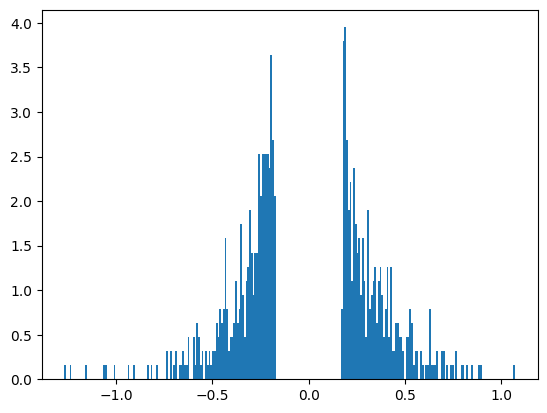

In [11]:
mask = (importance > threshold)

pruned_x = x.mul_(mask)

pruned_els = num_el - pruned_x.count_nonzero()
print(f"Found {pruned_els} zeros post-pruning.")

to_plot = pruned_x.view(-1)
to_plot = to_plot[to_plot != 0].view(-1)
plt.hist(to_plot, bins=bins, density=True)
plt.show()

## Pruning our Model

Now that we've explored the basics of pruning at the tensor level, we can start applying this technique to the entire VGG model. To streamline the pruning process across the model's numerous layers, we'll implement a utility class called `FineGrainedPruner`. This class will encapsulate the pruning procedure, allowing us to apply it systematically to every weight tensor in the model.

The `FineGrainedPruner` class will make it easy to perform pruning across the entire VGG model. Thanks to PyTorch's flexible architecture, we can individually access the weights of each layer within the model, making it straightforward to apply the pruning mask to every relevant tensor. By iterating through the model's layers, the `FineGrainedPruner` will ensure that all unimportant connections are zeroed out, reducing the model's complexity while maintaining its overall performance.

In [12]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940

@torch.no_grad()
def fine_grained_prune(tensor: torch.Tensor, sparsity: float) -> torch.Tensor:
    """
    Perform magnitude-based pruning for a single tensor.

    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return: torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = torch.abs(tensor)
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    mask = importance > threshold

    tensor.mul_(mask)

    return mask

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        """
        Initialize the FineGrainedPruner with a model and sparsity dictionary.

        :param model: torch.nn.Module, the model to be pruned
        :param sparsity_dict: dict, keys are parameter names, values are sparsity levels
        """
        self.masks = self._prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        """
        Apply the computed masks to the model's parameters.

        :param model: torch.nn.Module, the model to apply masks to
        """
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def _prune(model, sparsity_dict):
        """
        Compute masks for pruning based on the sparsity dictionary.

        :param model: torch.nn.Module, the model to be pruned
        :param sparsity_dict: dict, keys are parameter names, values are sparsity levels
        :return: dict, parameter names to their corresponding masks
        """
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1:  # we only prune conv and fc weights
                if name in sparsity_dict:
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

When applying pruning across a model, we still need to determine how much of each tensor should be pruned. However, using a uniform pruning ratio for all tensors might not be the most effective approach. Some tensors are larger or more sensitive than others, meaning that pruning them by the same amount could disproportionately impact the overall model performance. Furthermore, Linear layers have a much higher number of parameters generally in these models in comparison to the Convolution layers.

To better understand this, we will plot the weight distributions for all convolutional and linear layers, as well as the distribution of the number of parameters across these layers. This will give us a clearer picture of the variation in tensor sizes and importance. 

Next, we'll conduct a **Sensitivity Search**, where we prune each layer *independently* and evaluate the model's performance after each isolated change—without any fine-tuning or calibration. This approach will help us identify which layers are more sensitive to pruning and will provide valuable insights into how to determine the optimal pruning ratios for each layer. This way, we can apply non-uniform pruning ratios that are tailored to the characteristics of each layer, ensuring a more effective and balanced pruning strategy.

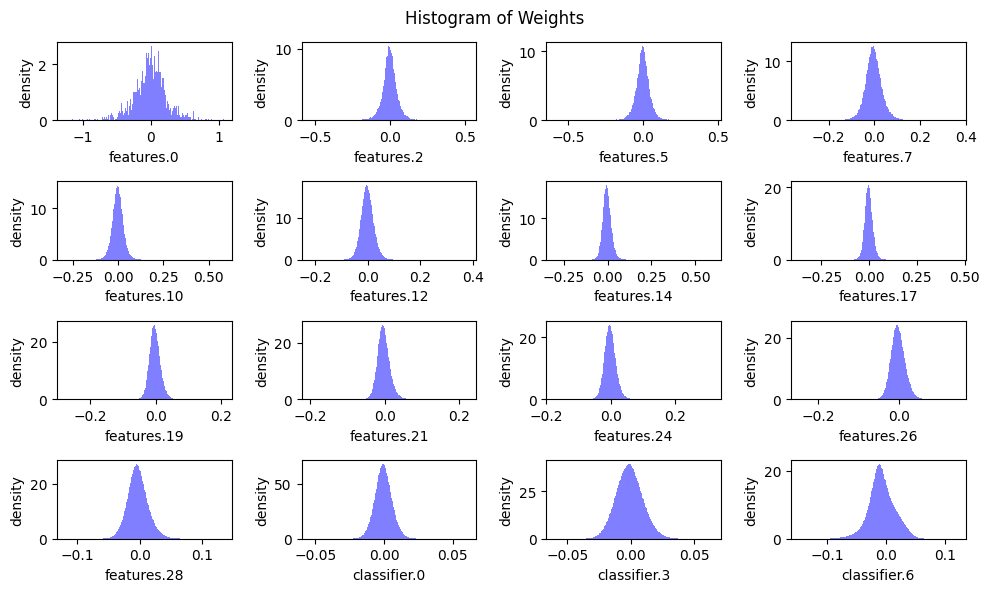

In [13]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(4, 4, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    
    for name, module in model.named_modules():
        if not isinstance(module, (nn.Conv2d, nn.Linear)):
            continue
        param = module.weight
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

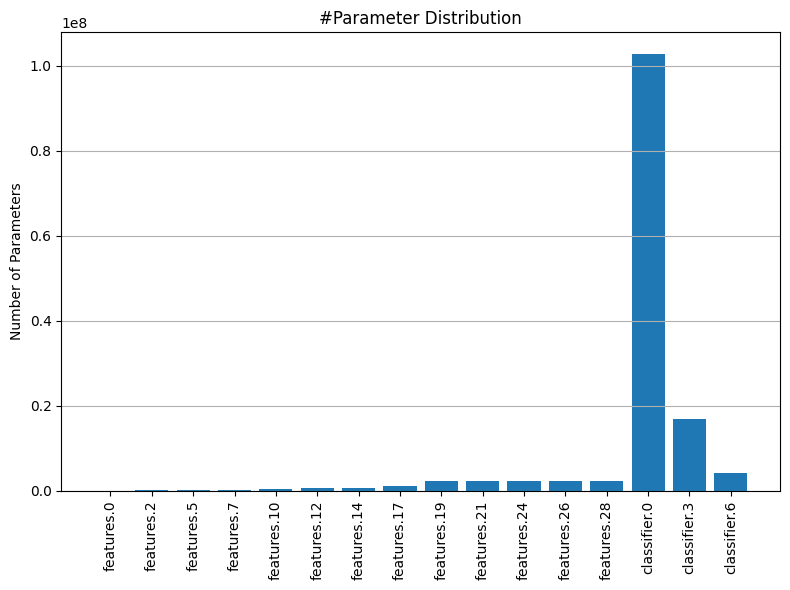

In [14]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, module in model.named_modules():
        if not isinstance(module, (nn.Conv2d, nn.Linear)):
            continue
        param = module.weight
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [15]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            _, acc = eval_step(model, dataloader, criterion, device)
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

sparsities, accuracies = sensitivity_scan(
    model, test_dl, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/16 weight - features.0.weight: 100%|██████████| 6/6 [01:29<00:00, 14.94s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.88, 0.86, 0.79, 0.64, 0.48, 0.26]

scanning 1/16 weight - features.2.weight: 100%|██████████| 6/6 [01:28<00:00, 14.83s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.88, 0.85]

scanning 2/16 weight - features.5.weight: 100%|██████████| 6/6 [01:29<00:00, 14.91s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.89, 0.84]

scanning 3/16 weight - features.7.weight: 100%|██████████| 6/6 [01:29<00:00, 14.95s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.87, 0.76]

scanning 4/16 weight - features.10.weight: 100%|██████████| 6/6 [01:29<00:00, 14.84s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.90, 0.88, 0.83]

scanning 5/16 weight - features.12.weight: 100%|██████████| 6/6 [01:26<00:00, 14.45s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.88, 0.84]

scanning 6/16 weight - features.14.weight: 100%|██████████| 6/6 [01:31<00:00, 15.20s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.89, 0.89, 0.85, 0.66]

scanning 7/16 weight - features.17.weight: 100%|██████████| 6/6 [01:28<00:00, 14.79s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.87, 0.75]

scanning 8/16 weight - features.19.weight: 100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.88, 0.80]

scanning 9/16 weight - features.21.weight: 100%|██████████| 6/6 [01:27<00:00, 14.62s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.88, 0.82]

scanning 10/16 weight - features.24.weight: 100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.90, 0.89, 0.84]

scanning 11/16 weight - features.26.weight: 100%|██████████| 6/6 [01:25<00:00, 14.21s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.88, 0.85]

scanning 12/16 weight - features.28.weight: 100%|██████████| 6/6 [01:30<00:00, 15.10s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.89, 0.88, 0.82]

scanning 13/16 weight - classifier.0.weight: 100%|██████████| 6/6 [01:32<00:00, 15.40s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.90, 0.90, 0.90]

scanning 14/16 weight - classifier.3.weight: 100%|██████████| 6/6 [01:31<00:00, 15.28s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.90, 0.90, 0.90, 0.90]

scanning 15/16 weight - classifier.6.weight: 100%|██████████| 6/6 [01:28<00:00, 14.67s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[0.90, 0.90, 0.89, 0.89, 0.89, 0.86]

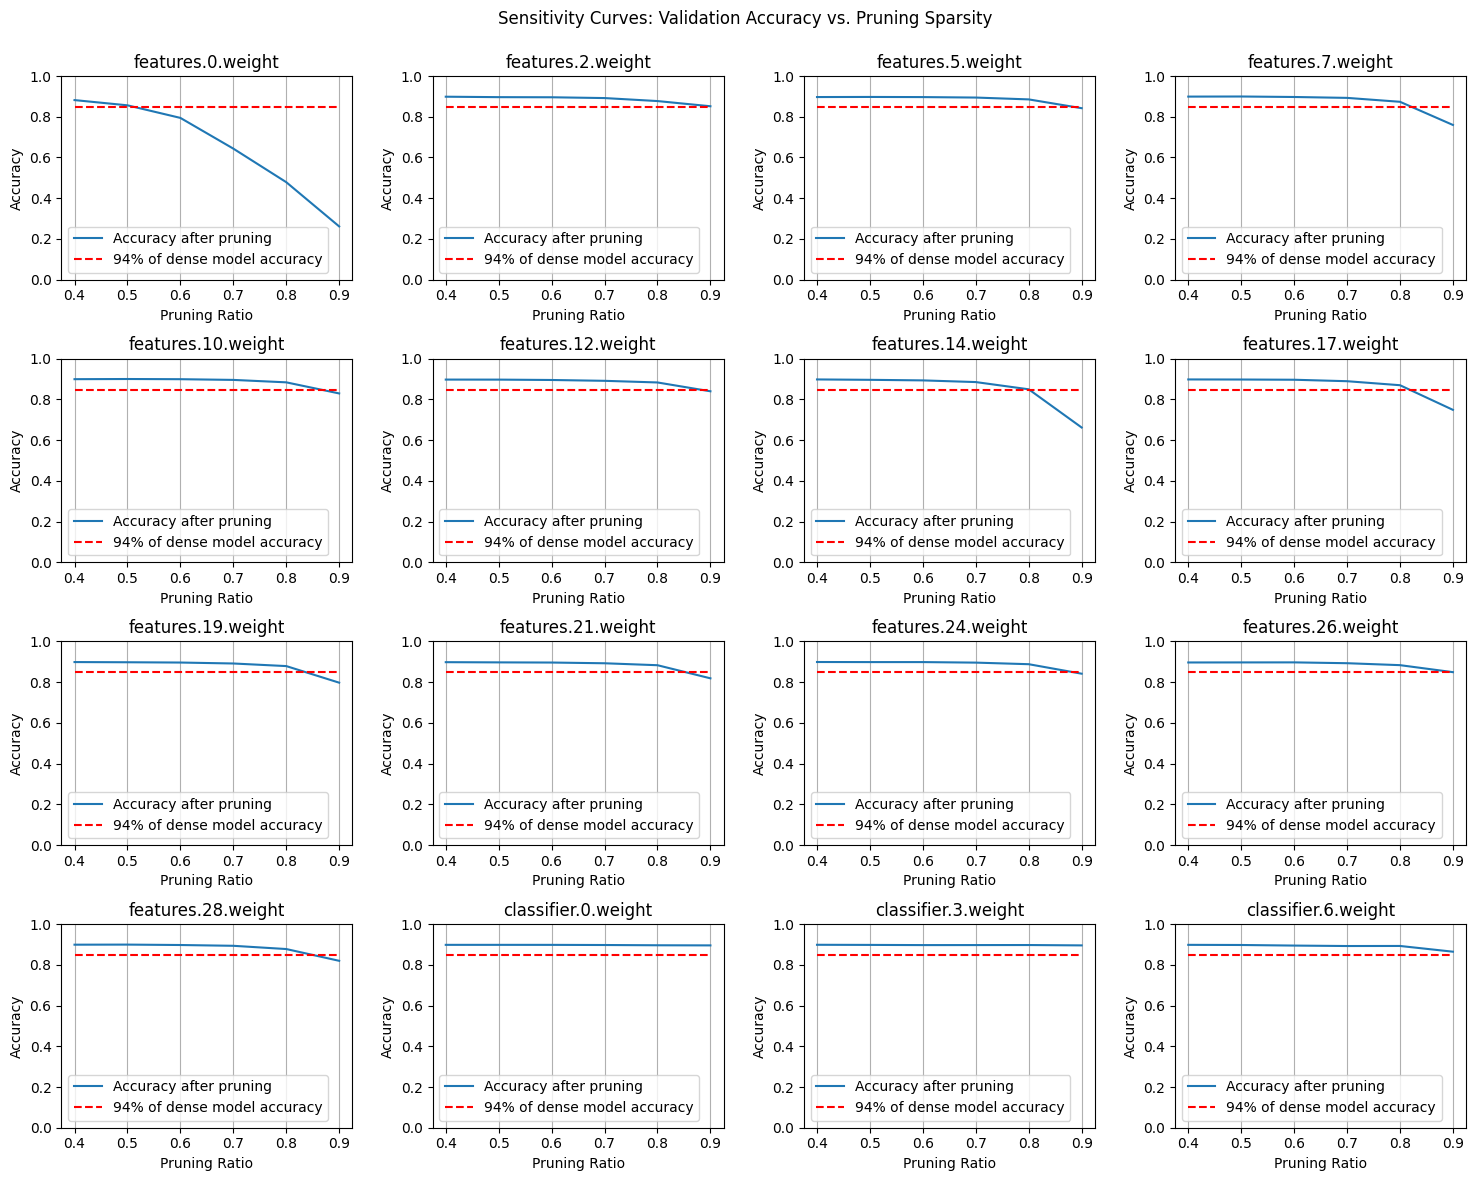

In [16]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    """
    Plot sensitivity curves for model pruning.

    :param sparsities: List or array of pruning sparsities.
    :param accuracies: List or array of accuracies corresponding to each sparsity.
    :param dense_model_accuracy: Accuracy of the model without pruning.
    """
    # Normalize dense model accuracy to the range of 0 to 1 if it's not already
    dense_model_accuracy = min(max(dense_model_accuracy, 0.0), 1.0)
    
    # Calculate lower bound accuracy for plotting reference line
    lower_bound_accuracy = 1 - (1 - dense_model_accuracy) * 1.5
    
    # Ensure lower_bound_accuracy is within [0, 1]
    lower_bound_accuracy = min(max(lower_bound_accuracy, 0.0), 1.0)
    
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.ravel()
    plot_index = 0
    
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            
            # Plot accuracy vs sparsity curve
            curve = ax.plot(sparsities, accuracies[plot_index], label='Accuracy after pruning')
            
            # Plot lower bound accuracy line
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities), '--', color='red', 
                           label=f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy')
            
            # Set x and y axis labels and limits
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(0, 1)  # Set y-axis limits to be between 0 and 1
            
            # Set title and labels
            ax.set_title(name)
            ax.set_xlabel('Pruning Ratio')
            ax.set_ylabel('Accuracy')
            
            # Add legend and grid
            ax.legend()
            ax.grid(axis='x')
            
            plot_index += 1
    
    # Adjust layout and title
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, val_acc)

After plotting the sensitivity curves and analyzing the distribution of parameters, we can use this information to decide how much to prune each layer. The sensitivity plots show how the model's performance changes as we increase the pruning ratio for each layer. Layers with more parameters and less sensitivity—where the performance curves show smaller dips as pruning increases—are typically more forgiving. This suggests that we can prune these layers more aggressively without significantly impacting the overall model performance.

Our goal is to prune as much as possible while maintaining the model's effectiveness. By focusing on layers with a high parameter count and low sensitivity, we can maximize the reduction in model complexity with minimal performance loss. This approach ensures that we optimize the pruning process, trimming away unnecessary components while preserving the key features that contribute to the model's success.

Sparse model size: 132.32 MiB = 25.07% of dense model size


Sparse model Accuracy: 0.84 (before finetuning)


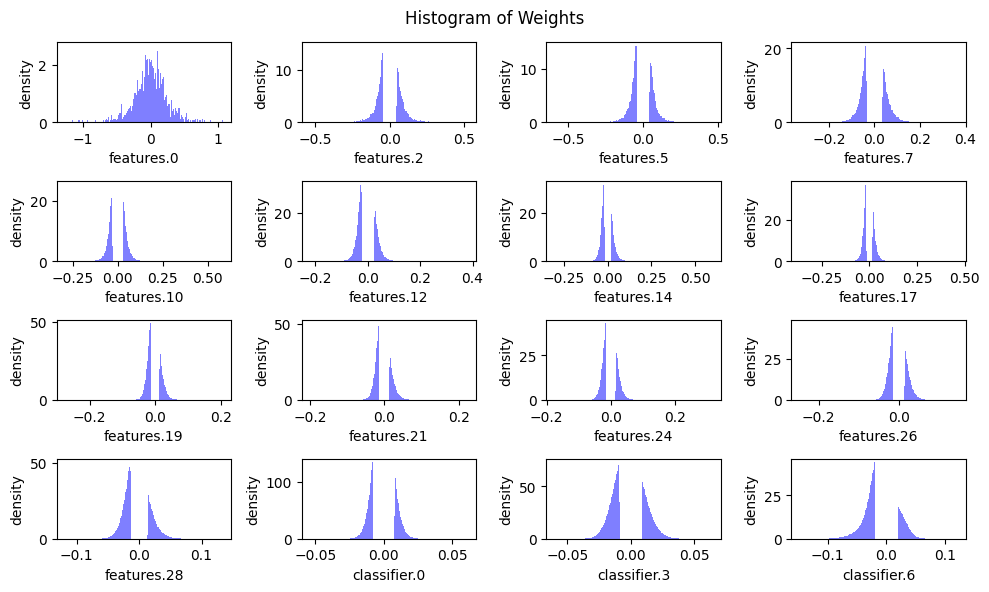

In [17]:
# Reference: https://hanlab.mit.edu/courses/2024-fall-65940
sparsity_dict = {
    'features.0.weight': 0, # very sensitive

    'features.2.weight': 0.7, # not sensitive
    'features.5.weight': 0.7,
    'features.7.weight': 0.7,
    'features.10.weight': 0.7,
    'features.12.weight': 0.7,

    'features.14.weight': 0.6, # little more sensitive
    'features.17.weight': 0.6,
    'features.19.weight': 0.6,
    'features.21.weight': 0.6,
    'features.24.weight': 0.6,
    'features.26.weight': 0.6,
    'features.28.weight': 0.6,

    'classifier.0.weight': 0.8, # not sensitive and has TOO many params
    
    'classifier.3.weight': 0.6, # not sensitive and has a good chunk of params
    'classifier.6.weight': 0.6
}

get_sparsity = lambda tensor: 1 - float(tensor.count_nonzero()) / tensor.numel()
pruner = FineGrainedPruner(model, sparsity_dict)

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model size: {sparse_model_size / (8 * 1024**2):.2f} MiB = {sparse_model_size / orig_model_size * 100:.2f}% of dense model size")
_, sparse_model_accuracy = eval_step(model, test_dl, criterion, device)
print(f"Sparse model Accuracy: {sparse_model_accuracy:.2f} (before finetuning)")

plot_weight_distribution(model, count_nonzero_only=True)

After pruning, our results show that we successfully reduced the model size by nearly 75%, with only a 6% drop in accuracy. While this is an impressive reduction, we don't have to stop here. 

It's a common practice to fine-tune the model post-pruning to recover some of the lost performance. This makes sense—suddenly forcing a smaller portion of the model to handle the full inference task can be overwhelming, so giving the model a chance to recalibrate itself is essential.

We will fine-tune the model for an additional three epochs, ensuring that pruning is reapplied after each step. This reinforcement is necessary because gradient descent during fine-tuning might adjust the previously pruned weights back to non-zero values. By consistently applying the pruning mask, we ensure that the model remains in its pruned state, allowing it to adapt to its new, more compact structure while regaining some of the lost performance.

In [18]:
for epoch in tqdm(range(epochs), desc="Epochs"):
    train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
    val_loss, val_acc = eval_step(model, test_dl, criterion, device)
    print(f"Epoch {epoch+1}... Train Accuracy: {train_acc:.2f} | Validation Accuracy: {val_acc:.2f}")
    pruner.apply(model)

Epochs:  33%|███▎      | 1/3 [03:09<06:19, 189.78s/it]

Epoch 1... Train Accuracy: 0.94 | Validation Accuracy: 0.89


Epochs:  67%|██████▋   | 2/3 [06:20<03:10, 190.46s/it]

Epoch 2... Train Accuracy: 0.95 | Validation Accuracy: 0.91


Epochs: 100%|██████████| 3/3 [09:32<00:00, 190.82s/it]

Epoch 3... Train Accuracy: 0.96 | Validation Accuracy: 0.91


In [19]:
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model size: {sparse_model_size / (8 * 1024**2):.2f} MiB = {sparse_model_size / orig_model_size * 100:.2f}% of dense model size")
_, sparse_model_accuracy = eval_step(model, test_dl, criterion, device)
print(f"Sparse model Accuracy: {sparse_model_accuracy:.2f} (after finetuning)")

Sparse model size: 132.32 MiB = 25.07% of dense model size


Sparse model Accuracy: 0.93 (after finetuning)


In conclusion, fine-grained pruning has enabled us to significantly reduce the number of effective parameters in our model, cutting down the model size by a substantial amount. The subsequent fine-tuning not only recovered much of the lost performance but actually improved the model's accuracy beyond its initial level. This results in a more efficient model that occupies only a quarter of the original storage cost.

Despite these gains, it's important to consider whether the time spent on fine-tuning, which remained the same as before, justifies the pruning. While fine-grained pruning can be highly effective, it also comes with its challenges. Zeroing out individual connections in the network is primarily beneficial with specialized hardware designed to handle sparse matrices efficiently. Without such hardware, the computational and memory overhead of working with sparsely populated tensors can offset some of the benefits of pruning.

In contrast, channel-wise pruning offers a more regular approach by removing entire channels or layers from the network. This method involves explicitly slicing out chunks of the parameter tensors, resulting in a model where the pruned parts are completely removed rather than simply zeroed out. This approach is often easier to implement and can be more compatible with standard hardware, making it a practical alternative to fine-grained pruning.

We will explore this in a future blog.